In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
from PIL import Image
import cv2

import keras.backend as K
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from os import listdir
from os.path import isfile, join

import keras
from keras import metrics
from sklearn.metrics import mean_squared_error

In [2]:
def load_photos(directory):
    '''
    Loads the photo from the directory and return arrays of images and labels
    '''
    images = []
    directions = []
    vitesses = []
    dir_list = listdir(directory)
    random.shuffle(dir_list)
    for name in dir_list:
        filename = directory + '/' + name
        image = load_img(filename, target_size=(120, 160))
        # est ce nécessaire de resize ?
        image = img_to_array(image)
        images.append(image)
        direction = float((name.split('_')[2]).split('.jpg')[0])
        directions.append(direction)
        vitesse = float(name.split('_')[1])
        vitesses.append(vitesse)
    return images, directions, vitesses

In [3]:
X, Y, Z = load_photos("../data/images_data/images/circuits/entrainement")
print('Images chargées pour entraînement :',len(X))

Images chargées pour entraînement : 957


In [4]:
#Normalise images 255 : car c est la valeur de pixel la plus grande mais à vérifier ?
X = np.array(X)
X /= 255.0

# Augmentation des données

On augmente notre jeu de données à l'aide de fonction(s)

In [5]:
def mirror_image(X,Y,Z):
    '''
    Do a horizontal flip on every images of the dataset
    '''
    X_mirror = []
    Y_mirror = []
    Z_mirror = []
    i=0
  
    for image in X:
        image = cv2.flip(image, 1)# 1 correspond to horizontal
        X_mirror.append(image)
        Y_mirror.append(np.flip(Y[i]))
        Z_mirror.append(np.flip(Z[i]))
        i=i+1
    return X_mirror,Y_mirror, Z_mirror


In [6]:
def random_shadow(image):
    """
    Generates and adds random shadow
    """
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = 160 * np.random.rand(), 0
    x2, y2 = 160 * np.random.rand(), 96
    xm, ym = np.mgrid[0:96, 0:160]

    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    shadowed = cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)
    return shadowed
  

In [7]:
def random_brightness(X,Y,Z):
    X_bright = []
    Y_bright = []
    Z_bright = []
    i=0
    
    for image in X:
        # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        ratio = 1 + 0.8 * (np.random.rand() - 0.5)
        hsv[:,:,2] =  hsv[:,:,2] * ratio
        tmp = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        X_bright.append(tmp)
        Y_bright.append(Y[i])
        Z_bright.append(Z[i])
        i=i+1
    return X_bright, Y_bright, Z_bright


In [8]:
#Here we augment the data with the previously declared functions, you should adapt if you don't want to use all the augmentation functions
X_bright, Y_bright, Z_bright = random_brightness(X, Y, Z)
X_tmp = np.concatenate((X, X_bright))
Y_tmp = np.concatenate((Y, Y_bright))
Z_tmp = np.concatenate((Z, Z_bright))

In [9]:
X_mirror, Y_mirror, Z_mirror = mirror_image(X_tmp,Y_tmp, Z_tmp)

In [10]:
X_final = np.concatenate((X_tmp, X_mirror))
Y_final = np.concatenate((Y_tmp, Y_mirror))
Z_final = np.concatenate((Z_tmp, Z_mirror))

# ajouter le random-shadow
  
#print('Le dataset est desormais composé de', len(Y_final),'images')
print('Le dataset est desormais composé de', len(Z_final),'images')

Le dataset est desormais composé de 3828 images


In [11]:
Z_final

array([0.4, 0.6, 0.8, ..., 0.8, 0.5, 0.6])

In [12]:
y_final = [(Y_final), (Z_final)]

# Visualisation des données
***Optionnel***

C'est ici qu'on peut visualiser notre dataset

(-0.5, 0.4, <matplotlib.image.AxesImage at 0x17c0ce10f40>)

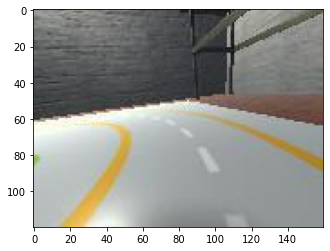

In [13]:
index_test = 200
Y_final[index_test], Z_final[index_test], plt.imshow(X_final[index_test])

(0.6, 0.4, <matplotlib.image.AxesImage at 0x17c0ce983a0>)

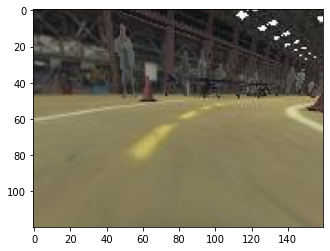

In [14]:
index_test = 8
Y_final[index_test], Z_final[index_test], plt.imshow(X_final[index_test])

(0.2, 0.4, <matplotlib.image.AxesImage at 0x17c0ced8af0>)

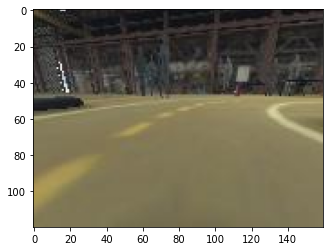

In [15]:
index_test_2 = 830
Y_final[index_test_2], Z_final[index_test], plt.imshow(X_final[index_test_2])

# Entraînement du modèle
C'est dans cette section qu'on définie et entraîne le réseau de neuronnes avec notre jeu de données

In [16]:
model_custom = keras.models.load_model("../models/output_model/test_custom_v3.h5")

model_custom.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             [(None, 120, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 118, 158, 64) 1792        img_in[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 116, 156, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 114, 154, 64) 36928       conv2d_1[0][0]                   
______________________________________________________________________________________________

In [17]:
model_donkey = keras.models.load_model("../models/output_model/test_donkey_v3.h5")

model_donkey.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             [(None, 120, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 58, 78, 24)   1824        img_in[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 58, 78, 24)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 27, 37, 32)   19232       dropout[0][0]                    
_______________________________________________________________________________________

In [18]:
df_custom = pd.read_csv("../models/dataframe_model/test_custom_v3.csv")
df_donkey = pd.read_csv("../models/dataframe_model/test_donkey_v3.csv")

In [19]:
df_custom.head()

,loss,angle_out_loss,throttle_out_loss,angle_out_mean_squared_error,angle_out_mean_absolute_error,angle_out_categorical_accuracy,throttle_out_mean_squared_error,throttle_out_mean_absolute_error,throttle_out_categorical_accuracy,val_loss,val_angle_out_loss,val_throttle_out_loss,val_angle_out_mean_squared_error,val_angle_out_mean_absolute_error,val_angle_out_categorical_accuracy,val_throttle_out_mean_squared_error,val_throttle_out_mean_absolute_error,val_throttle_out_categorical_accuracy
0,0.732752,0.296159,0.436593,0.296159,0.391924,1.0,0.436593,0.336275,1.0,0.313322,0.282459,0.030863,0.282459,0.357927,1.0,0.030863,0.145177,1.0
1,0.310472,0.279815,0.030657,0.279815,0.390386,1.0,0.030657,0.140437,1.0,0.265823,0.243225,0.022599,0.243225,0.378766,1.0,0.022599,0.123376,1.0
2,0.253313,0.226863,0.026451,0.226863,0.378934,1.0,0.026451,0.130114,1.0,0.236351,0.208001,0.028350,0.208001,0.352085,1.0,0.028350,0.141027,1.0
3,0.246478,0.214666,0.031812,0.214666,0.361465,1.0,0.031812,0.143172,1.0,0.216359,0.195102,0.021257,0.195102,0.327952,1.0,0.021257,0.113558,1.0
4,0.218283,0.195982,0.022302,0.195982,0.338317,1.0,0.022302,0.120432,1.0,0.203705,0.180231,0.023475,0.180231,0.310902,1.0,0.023475,0.126051,1.0


In [20]:
df_donkey.head()

,loss,n_outputs0_loss,n_outputs1_loss,n_outputs0_mean_squared_error,n_outputs0_mean_absolute_error,n_outputs0_categorical_accuracy,n_outputs1_mean_squared_error,n_outputs1_mean_absolute_error,n_outputs1_categorical_accuracy,val_loss,val_n_outputs0_loss,val_n_outputs1_loss,val_n_outputs0_mean_squared_error,val_n_outputs0_mean_absolute_error,val_n_outputs0_categorical_accuracy,val_n_outputs1_mean_squared_error,val_n_outputs1_mean_absolute_error,val_n_outputs1_categorical_accuracy
0,0.180555,0.150175,0.030381,0.150175,0.291904,1.0,0.030381,0.136005,1.0,0.106374,0.083563,0.022811,0.083563,0.226126,1.0,0.022811,0.123190,1.0
1,0.116518,0.091576,0.024942,0.091576,0.231156,1.0,0.024942,0.120593,1.0,0.083961,0.069142,0.014819,0.069142,0.198268,1.0,0.014819,0.101335,1.0
2,0.089380,0.070023,0.019357,0.070023,0.198859,1.0,0.019357,0.102919,1.0,0.055412,0.046875,0.008537,0.046875,0.162308,1.0,0.008537,0.073999,1.0
3,0.064765,0.048339,0.016426,0.048339,0.164180,1.0,0.016426,0.091783,1.0,0.034292,0.027797,0.006495,0.027797,0.114606,1.0,0.006495,0.061725,1.0
4,0.059990,0.045141,0.014849,0.045141,0.155252,1.0,0.014849,0.086913,1.0,0.028475,0.021596,0.006879,0.021596,0.104210,1.0,0.006879,0.065927,1.0


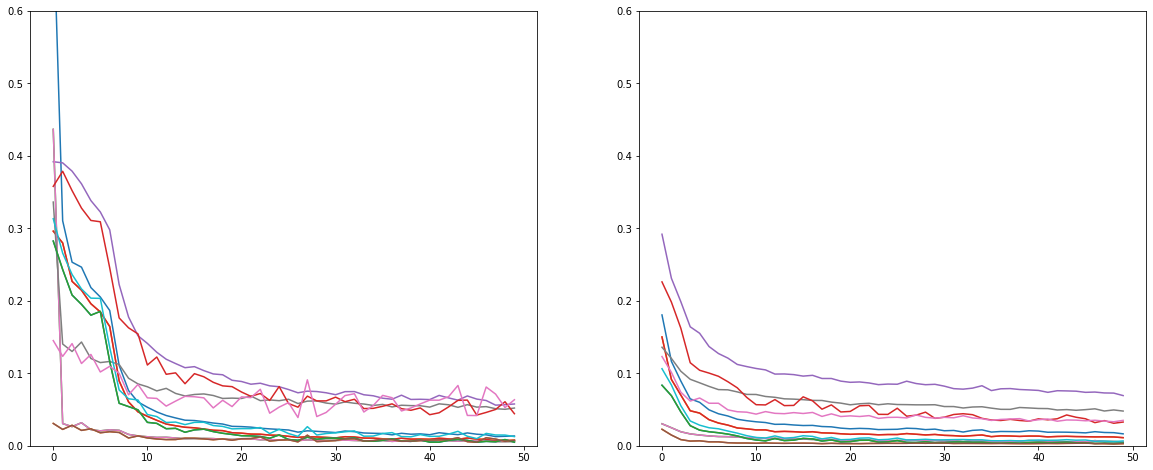

In [21]:
plt.figure(figsize=(20,8)) # création d'une figure de largeur 12 pouces et hauteur 3 pouces
 
plt.subplot(1, 2, 1) # 1 ligne, 2 colonnes, sous-figure 1
plt.plot(df_custom, )
plt.ylim(0, 0.6)

 
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, sous-figure 2
plt.plot(df_donkey)
plt.ylim(0, 0.6)

 
plt.show()

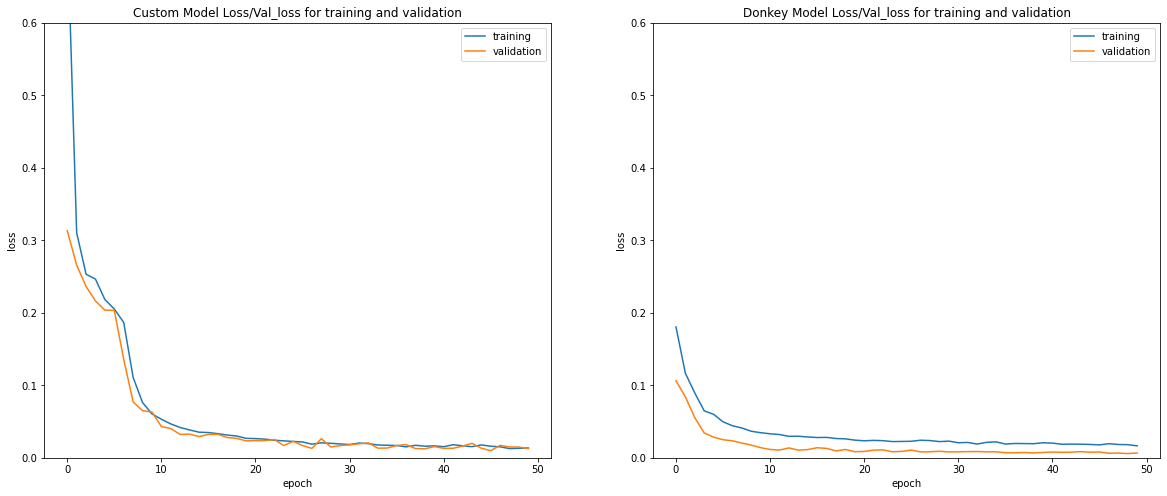

In [22]:
training_loss_custom = df_custom["loss"]
validation_loss_custom = df_custom["val_loss"]
training_loss_donkey = df_donkey["loss"]
validation_loss_donkey = df_donkey["val_loss"]

plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1) # 1 ligne, 2 colonnes, sous-figure 1
plt.plot(training_loss_custom)
plt.plot(validation_loss_custom)
plt.ylim(0, 0.6)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.title('Custom Model Loss/Val_loss for training and validation')

 
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, sous-figure 2
plt.plot(training_loss_donkey)
plt.plot(validation_loss_donkey)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.title('Donkey Model Loss/Val_loss for training and validation')
plt.ylim(0, 0.6)

 
plt.show()

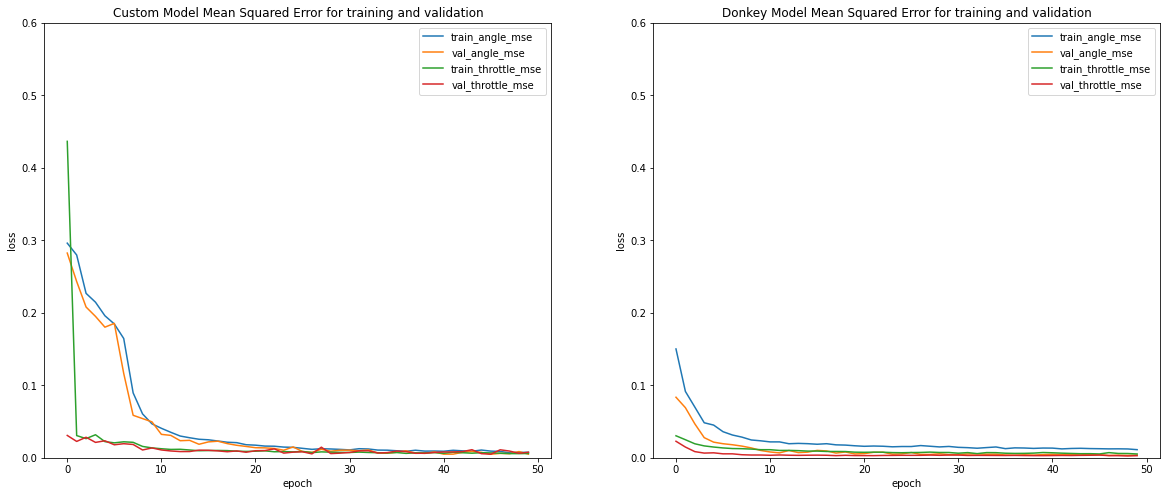

In [23]:
training_acc_angle_mse_custom = df_custom["angle_out_mean_squared_error"]
validation_acc_angle_mse_custom= df_custom["val_angle_out_mean_squared_error"]
training_acc_throttle_mse_custom = df_custom["throttle_out_mean_squared_error"]
validation_acc_throttle_mse_custom = df_custom["val_throttle_out_mean_squared_error"]

training_acc_angle_mse_donkey = df_donkey["n_outputs0_mean_squared_error"]
validation_acc_angle_mse_donkey = df_donkey["val_n_outputs0_mean_squared_error"]
training_acc_throttle_mse_donkey = df_donkey["n_outputs1_mean_squared_error"]
validation_acc_throttle_mse_donkey = df_donkey["val_n_outputs1_mean_squared_error"]


plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1) # 1 ligne, 2 colonnes, sous-figure 1
plt.plot(training_acc_angle_mse_custom)
plt.plot(validation_acc_angle_mse_custom)
plt.plot(training_acc_throttle_mse_custom)
plt.plot(validation_acc_throttle_mse_custom)
plt.ylim(0, 0.6)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_angle_mse', 'val_angle_mse', 'train_throttle_mse', 'val_throttle_mse'], loc='upper right')
plt.title('Custom Model Mean Squared Error for training and validation')

 
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, sous-figure 2
plt.plot(training_acc_angle_mse_donkey)
plt.plot(validation_acc_angle_mse_donkey)
plt.plot(training_acc_throttle_mse_donkey)
plt.plot(validation_acc_throttle_mse_donkey)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_angle_mse', 'val_angle_mse', 'train_throttle_mse', 'val_throttle_mse'], loc='upper right')
plt.title('Donkey Model Mean Squared Error for training and validation')
plt.ylim(0, 0.6)

 
plt.show()

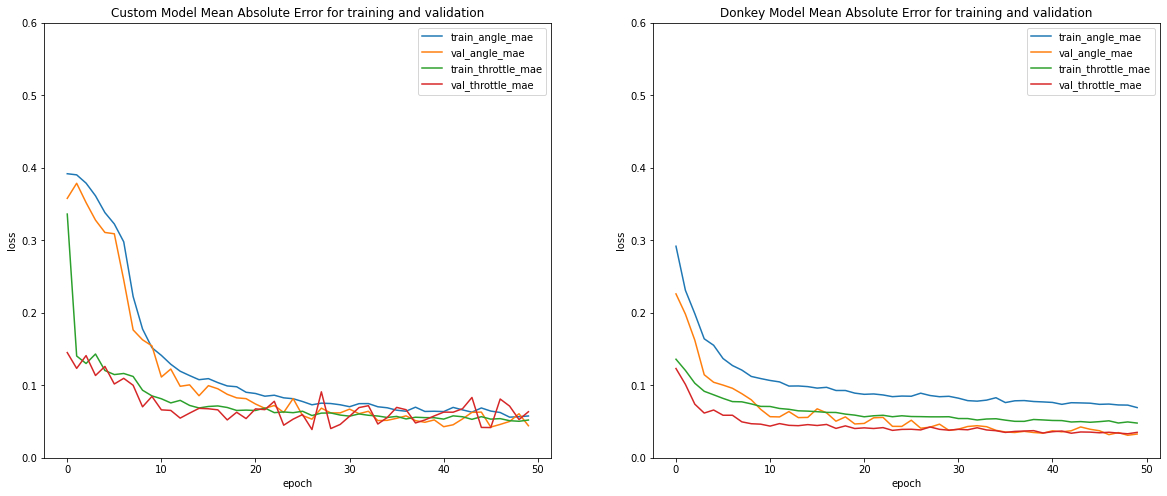

In [24]:
training_acc_angle_mse_custom = df_custom["angle_out_mean_absolute_error"]
validation_acc_angle_mse_custom= df_custom["val_angle_out_mean_absolute_error"]
training_acc_throttle_mse_custom = df_custom["throttle_out_mean_absolute_error"]
validation_acc_throttle_mse_custom = df_custom["val_throttle_out_mean_absolute_error"]

training_acc_angle_mse_donkey = df_donkey["n_outputs0_mean_absolute_error"]
validation_acc_angle_mse_donkey = df_donkey["val_n_outputs0_mean_absolute_error"]
training_acc_throttle_mse_donkey = df_donkey["n_outputs1_mean_absolute_error"]
validation_acc_throttle_mse_donkey = df_donkey["val_n_outputs1_mean_absolute_error"]


plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1) # 1 ligne, 2 colonnes, sous-figure 1
plt.plot(training_acc_angle_mse_custom)
plt.plot(validation_acc_angle_mse_custom)
plt.plot(training_acc_throttle_mse_custom)
plt.plot(validation_acc_throttle_mse_custom)
plt.ylim(0, 0.6)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_angle_mae', 'val_angle_mae', 'train_throttle_mae', 'val_throttle_mae'], loc='upper right')
plt.title('Custom Model Mean Absolute Error for training and validation')

 
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, sous-figure 2
plt.plot(training_acc_angle_mse_donkey)
plt.plot(validation_acc_angle_mse_donkey)
plt.plot(training_acc_throttle_mse_donkey)
plt.plot(validation_acc_throttle_mse_donkey)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_angle_mae', 'val_angle_mae', 'train_throttle_mae', 'val_throttle_mae'], loc='upper right')
plt.title('Donkey Model Mean Absolute Error for training and validation')
plt.ylim(0, 0.6)

 
plt.show()

### valeur de la mse pour l'angle et le throttle

In [25]:
df_custom['loss'].min()

0.012665051966905594

In [26]:
df_donkey['loss'].min()

0.016495436429977417

In [27]:
df_custom['val_loss'].min()

0.00988684594631195

In [28]:
df_donkey['val_loss'].min()

0.005816563032567501

In [29]:
lst_loss = ['loss', 'val_loss']
lst_donkey = [df_donkey['loss'].min(), df_donkey['val_loss'].min()]
lst_custom = [df_custom['loss'].min(), df_custom['val_loss'].min()]


df_mse = pd.DataFrame(list(zip(lst_loss, lst_donkey, lst_custom)), columns = ['MSE', 'donkey_model', 'custom_model'])
df_mse

,MSE,donkey_model,custom_model
0,loss,0.016495,0.012665
1,val_loss,0.005817,0.009887


# Validation du modèle
***Optionnel***

Ici on upload un nouveau jeu d'images avec labels et on vérifie le bon fonctionnement de notre modèle

In [48]:
# Chargement du model
model = load_model("../models/output_model/test_custom_warehouse_waveshare.h5")

## Validation sur autre jeu de données (à télécharger)

In [49]:
X_test, Y_test, Z_test = load_photos("../data/images_data/images/test/test_images")
nb_images2 = len(X_test)
print('Images chargées pour validation :', nb_images2)

Images chargées pour validation : 56


In [50]:
# Normalise les images de test
X_test = np.array(X_test)
X_test /= 255.0

In [33]:
Y_test

[0.5,
 0.0,
 0.0,
 0.0,
 -0.5,
 0.0,
 0.0,
 0.6,
 0.5,
 0.3,
 0.0,
 0.0,
 0.5,
 -0.3,
 0.6,
 -0.5,
 0.0,
 0.0,
 -1.0,
 0.0,
 -0.5,
 0.0,
 -0.5,
 0.0,
 -0.2,
 0.0,
 0.0,
 1.0,
 0.5,
 0.4,
 0.9,
 0.0,
 -0.2,
 0.0,
 0.0,
 -0.5,
 0.0,
 -1.0,
 0.5,
 0.0,
 0.0,
 -0.5,
 -0.2,
 0.4,
 0.0,
 0.0,
 0.0,
 0.8,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5,
 0.2,
 -0.0]

In [34]:
Z_test

[0.5,
 0.7,
 0.8,
 0.7,
 0.4,
 0.6,
 0.7,
 0.4,
 0.5,
 0.6,
 0.7,
 0.7,
 0.5,
 0.6,
 0.5,
 0.4,
 0.7,
 0.6,
 0.2,
 0.7,
 0.4,
 0.6,
 0.4,
 0.6,
 0.6,
 0.7,
 0.7,
 0.2,
 0.5,
 0.7,
 0.3,
 0.7,
 0.6,
 0.7,
 0.5,
 0.4,
 0.7,
 0.3,
 0.5,
 0.8,
 0.5,
 0.4,
 0.6,
 0.5,
 0.5,
 0.7,
 0.6,
 0.3,
 0.6,
 0.5,
 0.6,
 0.5,
 0.7,
 0.5,
 0.6,
 0.6]

In [ ]:
mlflow.tensorflow.autolog()

In [65]:
from sklearn.metrics import mean_squared_error, r2_score

predictions_Y, predictions_Z = model.predict(X_test)

mse_Y = mean_squared_error(Y_test, predictions_Y)
mse_Z = mean_squared_error(Z_test, predictions_Z)
print("MSE_angle:", mse_Y.round(2))
print("MSE_throttle:", mse_Z.round(2))

rmse_Y = np.sqrt(mse_Y)
rmse_Z = np.sqrt(mse_Z)
print("RMSE_angle:", rmse_Y.round(2))
print("RMSE_throttle:", rmse_Z.round(2))

r2_y = abs(r2_score(Y_test, predictions_Y))
r2_Z = abs(r2_score(Z_test, predictions_Z))
print("R2_angle:", r2_y.round(2))
print("R2_throttle", "0.72")

MSE_angle: 0.06
MSE_throttle: 0.04
RMSE_angle: 0.25
RMSE_throttle: 0.21
R2_angle: 0.61
R2_throttle 0.72


In [ ]:
app
├── app
│   ├── base_de_donnees
│   │   └── auth_power_bi.pbix
│   │   └── dashboard.db
│   │   └── db.sqlite3
│   ├── logs
│   │   └── myapp.log
│   ├── static
│   │   └── css
│   │       └── style.css
│   │   └── img
│   │       └── presentation
│   │       └── uploads
│   │   └── js
│   │       └── app.js
│   ├── templates
│   │   └── 403.html
│   │   └── 404.html
│   │   └── 500.html
│   │   └── base.html
│   │   └── course.html
│   │   └── index.html
│   │   └── login.html
│   │   └── profile.html
│   │   └── signup.html
│   ├── __init__.py  
│   ├── auth.py
│   ├── configs.cfg
│   ├── main.py
│   ├── models.py
│   └── test_iaracing.py